# Read Me

- Energy density, pulse width --> voltage function

In [1]:
import sys
import os
import argparse

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from torch.optim import Adam as Adam
from emukit.core import ParameterSpace, ContinuousParameter
from tkinter import Y
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import matplotlib.pyplot as plt
sys.path.append('..')
sys.path.insert(0, '../src')

# custom modules
from grid import Grid
from train_eval_plotter import prettyplot, plot_gp_res

In [2]:
parser = argparse.ArgumentParser(description='Ferroelectric GP')
parser.add_argument('--grid_dim', type=int, default=30, metavar='TR',
                    help='number of test points per parameter (default: 30)')
parser.add_argument('--train_flag', type=bool, default=True, metavar='TR',
                    help='train or load pre-saved model (default: True)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
                    
args = parser.parse_args("")

# Set random seed to reproduce results
torch.manual_seed(args.seed)

## Data Loading

In [3]:
dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/"
acq_df = pd.read_csv(dir + "predictions/preds.csv", index_col=False)
# acq_df_emu = pd.read_csv(dir + "predictions/emu_preds", index_col=False) 
# acq_df = pd.concat([acq_df_torch, acq_df_emu])
acq_df.iloc[:, 1:] = acq_df.iloc[:, 1:].applymap(lambda vals: np.round(vals,2))
print(acq_df)

    Acq  Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6
0   qEI       4.79                             14.49               3.16
1   qEI       4.70                             15.29               3.04
2   qEI       1.47                              9.16               3.87
3   qEI       1.49                              8.88               3.98
4  qUCB       4.22                              1.28               2.81
5  qUCB       5.00                              2.28               2.81
6  qUCB       4.58                             14.89               2.93
7  qUCB       1.37                              9.81               3.09


In [4]:
in_file = "data/Bolometer_readings_under_the_cone_new_old.xlsx"
df = pd.read_excel(dir + in_file, sheet_name="Calibrations_new")
df2 = pd.read_excel(dir + in_file, sheet_name= "Beamtime")
df2 = df2[df2['upulses'] == 1]

volts_bol_dat = np.concatenate((df['Voltage (V)'].values, df2['Voltage (V)'].values))
time_bol_dat = np.concatenate((df['Time (us)'].values, df2['Time (us)'].values))
energy_den_bol_dat = np.concatenate((df['Energy density new cone (J/cm^2)'].values, 
                            df2['Energy density new cone (J/cm^2)'].values))  

In [5]:
# define scaler
post_scaler = MinMaxScaler()
def norm_x(x_tensor, scaler): return scaler.fit_transform(x_tensor)
def un_norm_x(x_tensor, scaler): return scaler.inverse_transform(x_tensor) 

# make, scale training set
x_exp_raw = np.stack((time_bol_dat, energy_den_bol_dat), axis=1)
x_exp = norm_x(x_exp_raw, post_scaler)

y_exp = np.reshape(volts_bol_dat,(-1,1))
X, Y = [x_exp, y_exp]

## GP Voltage Model

In [6]:
# make GP grid; min delta time: 500us, min delta energy density: 0.01J/cm^2
def grid_maker_1D(arr, step_size):
    return np.arange(arr.min(), arr.max()+step_size*0.1,step_size)
    
var_array = [grid_maker_1D(time_bol_dat, 500), grid_maker_1D(energy_den_bol_dat, 0.01)]

# continuous parameter creates a grid space for grid search
time_len_num, e_den_num = len(var_array[0]), len(var_array[1])
parameter_space = ParameterSpace([ContinuousParameter("Time (ms)", 0-1/(time_len_num-1)/2, 1+1/(time_len_num-1)/2),
                                  ContinuousParameter("Energy density new cone (J/cm^2)", 0-1/(e_den_num-1)/2, 1+1/(e_den_num-1)/2),
                                 ])

### Make GP Model

In [7]:
# define GP kernel
kernel = GPy.kern.src.stationary.Exponential(input_dim = len(X[0]), ARD =True)
kernel.lengthscale.constrain_bounded(1e-2, 1)
kernel.variance.constrain_bounded(1e-2, 500.0)

reconstraining parameters Exponential.lengthscale
reconstraining parameters Exponential.variance


## Train Model

In [8]:
# set up dir for file search
cur_dir = os.getcwd()
par_dir = os.path.dirname(cur_dir)
model_dir = os.path.join(par_dir, 'models')

if args.train_flag: 
    model_volt = GPRegression(X , -Y, kernel) # emukit is a minimizer
    model_volt.Gaussian_noise.variance = 0.15
    model_volt.Gaussian_noise.variance.fix()
    model_volt.randomize() # init random hyperparameters

    model_volt.optimize_restarts(num_restarts=30, verbose =False, messages=False) # fit to training data, select best hyperparameters out of num_restarts 
    objective_model = GPyModelWrapper(model_volt)
    print(model_volt)
    np.save(model_dir + '/volt_model_state.npy', model_volt.param_array)
else:
    # Load trained model
    model_volt = GPy.models.GPRegression(X, Y, initialize=True, kernel=kernel)
    model_volt.update_model(False) 
    model_volt[:] = np.load(model_dir + '/volt_model_state.npy') 
    model_volt.update_model(True) 
    print(model_volt)


Name : GP regression
Objective : 2159.059093533782
Number of Parameters : 4
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  Exponential.variance     |  499.9999995129824  |  0.01,500.0   |        
  Exponential.lengthscale  |               (2,)  |   0.01,1.0    |        
  Gaussian_noise.variance  |               0.15  |   +ve fixed   |        


In [9]:
# predict voltage training set
gp_func = objective_model.model.predict
y_pred, y_err = gp_func(X)
y_pred, y_err = -y_pred[:,-1], np.sqrt(y_err[:,-1])

### Plot Training Results

     Metric  Value
0      RMSE  0.110
1       MAE  0.075
2  Spearman  0.992
3  R² score  1.000


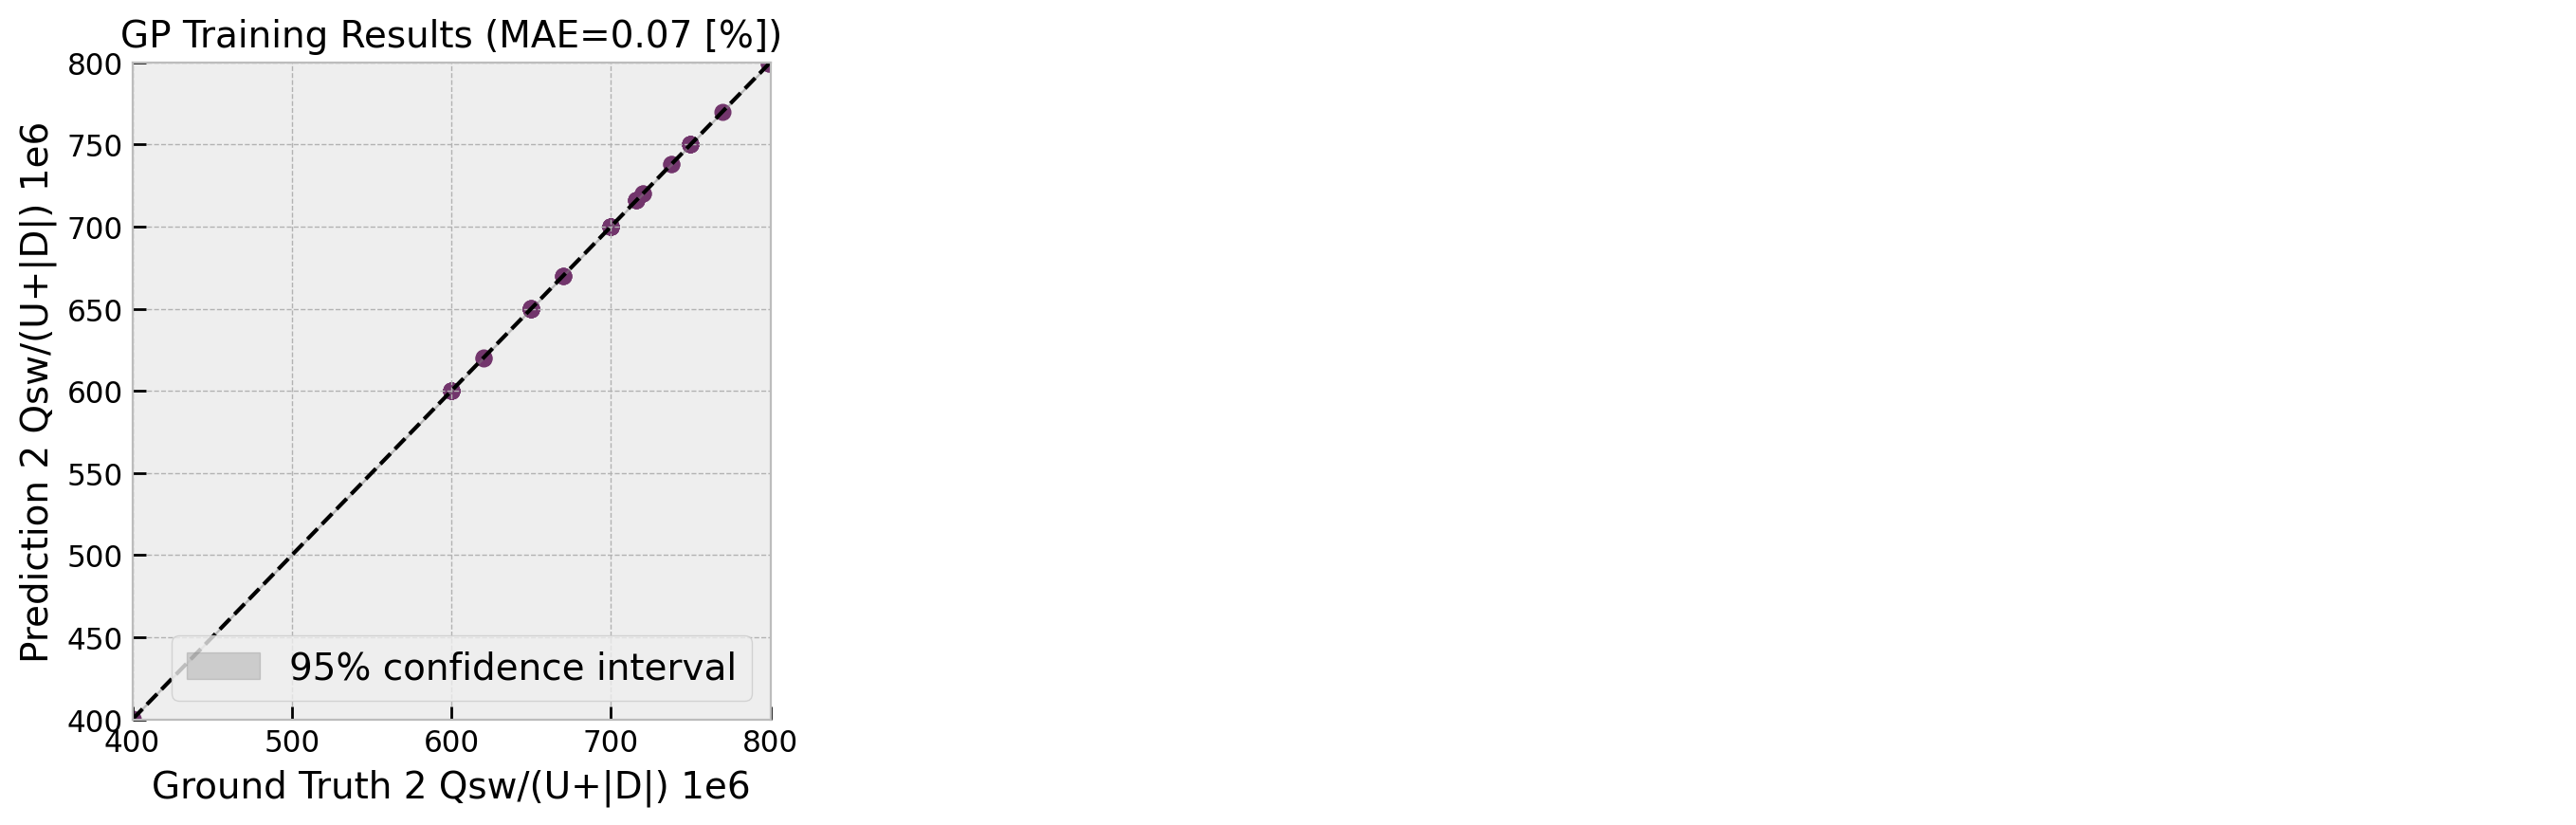

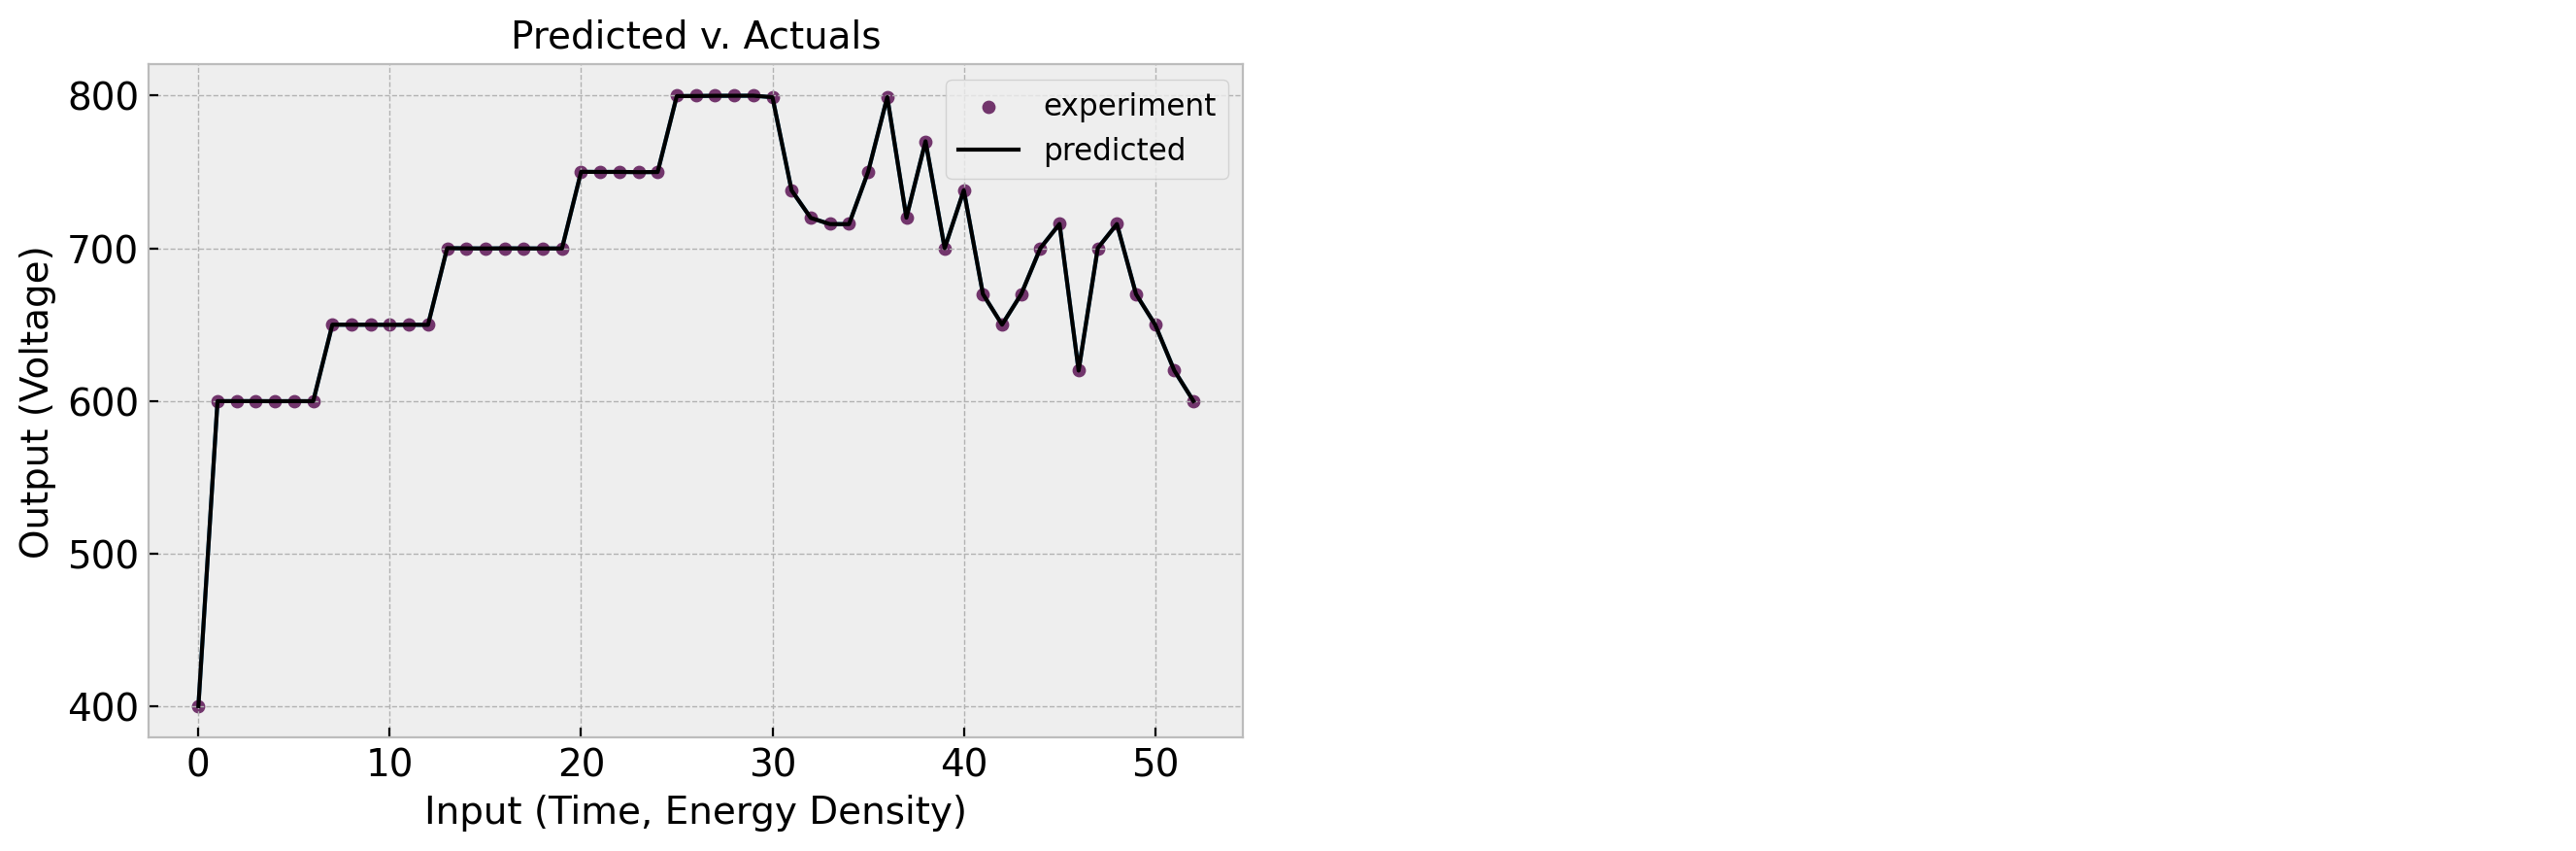

In [10]:
# plot voltage training results 
plot_gp_res(y_exp.reshape(-1), y_pred, None, y_err)
prettyplot()

# plot actuals v. predicted values w/ error bars
fs = 14 
fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))
plt_inputs = np.arange(len(Y))
axes[0].scatter(plt_inputs, Y[:,0].T, s = 20, color = "#72356c", label = 'experiment')
axes[0].plot(plt_inputs, y_pred, color = 'black', label = 'predicted')
axes[0].errorbar(plt_inputs, y_pred, y_err, zorder = 0)

# set up axes and labels
axes[0].set_ylabel('Output (Voltage)', fontsize = fs)
axes[0].set_xlabel('Input (Time, Energy Density)', fontsize = fs)
axes[0].set_title("Predicted v. Actuals", fontsize = fs)
axes[0].legend(fontsize = fs*0.8)
axes[1].axis("off")

plt.show()

## Mean Posterior Predictions

In [11]:
# get voltages of prediction points and re-scale to raws
get_pos_volt = lambda pt: np.round(-1*(gp_func(pt)[0]),0)
acq_time = acq_df.iloc[:,1].values * 1000
acq_energy =  acq_df.iloc[:,2].values
acq_scaled = post_scaler.transform(np.stack((acq_time,acq_energy), axis=1))
acq_volt = get_pos_volt(acq_scaled)
acq_df_volt = acq_df.copy() 
acq_df_volt["Voltage (V)"] = acq_volt

In [12]:
# write to csv
dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/predictions/"
file_out = "final_preds.csv"
acq_df_volt.to_csv(dir + file_out, index=False)

In [13]:
# make, scale post_test_grid
grid = Grid(torch.Tensor(X))
post_test_grid, post_test_arr = grid.test_grid, grid.test_arr
volt_on_grid, _ = gp_func(post_test_arr.numpy())
volt_on_grid = -1 * volt_on_grid.reshape(args.grid_dim,args.grid_dim).T
raw_post_test_arr = un_norm_x(post_test_arr,post_scaler) 
raw_post_test_grid = un_norm_x(post_test_grid, post_scaler)

### Plot Results

In [14]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

fig = go.Figure(data=[go.Scatter3d(z=volts_bol_dat, x=time_bol_dat, y=energy_den_bol_dat, 
                                    mode='markers', marker={'color':'#72356c'},
                                    name='Data')])
fig.add_trace(go.Surface(z=volt_on_grid, x=raw_post_test_grid[:,0], y=raw_post_test_grid[:,1],
                            opacity=0.8, colorscale = "Burg", colorbar=dict(thickness=15, len=0.5)))
# fig.add_trace(go.Scatter3d(z=volt_on_grid, x=raw_post_test_grid[:,0], y=raw_post_test_grid[:,1],
#                             opacity=0.8, colorscale = "Burg", colorbar=dict(thickness=15, len=0.5)))
fig.update_layout(width=1000, height=800, legend=dict(orientation="h", yanchor="top", y=1.02, 
                xanchor="left",x=1), margin=dict(r=20, l=10, b=10, t=10), 
                scene=dict(xaxis_title="Pulse width (μs)", 
                        yaxis_title="Energy density new cone (J/cm^2)",
                        zaxis_title='Voltage'))
camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), 
                eye=dict(x=-2, y=-2.5, z=1.75))
fig.update_layout(scene_camera=camera)
fig.update_layout(template="ggplot2")
fig.show()